# Dynamic UNet using Exai

In [1]:
# Install required libraries
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install nibabel
!pip install imageio
!pip install opencv-python
!pip install ipywidgets
!pip install tqdm
!pip install fastai

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm 
from ipywidgets import *
from PIL import Image

In [3]:
import fastai; fastai.__version__

'1.0.64.dev0'

In [5]:
!pip install fastai==2.7.11  
!pip install torch==1.13.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached fastai-2.7.11-py3-none-any.whl.metadata (9.6 kB)
  Using cached fastdownload-0.0.7-py3-none-any.whl.metadata (5.5 kB)
  Using cached fastcore-1.5.55-py3-none-any.whl.metadata (3.5 kB)
  Using cached spacy-3.8.2.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [91 lines of output]
      Ignoring numpy: markers 'python_version >= "3.9"' don't match your environment
        Using cached setuptools-75.3.0-py3-none-any.whl.metadata (6.9 kB)
        Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
        Using cached cymem-2.0.10.tar.gz (10 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached preshed-3.0.9-cp38-cp38-win_amd64.whl.metadata (2.2 kB)
        Using cached murmurhash-1.0.11.tar.gz (13 kB)
        Installing build dependencies: started
        Insta

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-1.13.0-cp38-cp38-win_amd64.whl.metadata (23 kB)
Using cached torch-1.13.0-cp38-cp38-win_amd64.whl (167.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1
    Uninstalling torch-2.4.1:
      Successfully uninstalled torch-2.4.1


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.19.1 requires torch==2.4.1, but you have torch 1.13.0 which is incompatible.


In [6]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

ModuleNotFoundError: No module named 'fastai.vision.all'

In [5]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('E:/New folder/segmentations'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        file_list.append((dirname,filename)) 

for dirname, _, filenames in os.walk('E:/data'):
    for filename in filenames:
        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
0,E:/New folder/segmentations,segmentation-0.nii
1,E:/New folder/segmentations,segmentation-1.nii
2,E:/New folder/segmentations,segmentation-10.nii
3,E:/New folder/segmentations,segmentation-100.nii
4,E:/New folder/segmentations,segmentation-101.nii
...,...,...
228,E:/data,volume-96.nii
229,E:/data,volume-97.nii
230,E:/data,volume-98.nii
231,E:/data,volume-99.nii


In [6]:
# Map CT scan and label 

df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "E:/New folder/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files

101


,dirname,filename,mask_dirname,mask_filename
0,E:/data,volume-0.nii,E:/New folder/segmentations,segmentation-0.nii
1,E:/data,volume-1.nii,E:/New folder/segmentations,segmentation-1.nii
2,E:/data,volume-10.nii,E:/New folder/segmentations,segmentation-10.nii
3,E:/data,volume-100.nii,E:/New folder/segmentations,segmentation-100.nii
4,E:/data,volume-11.nii,E:/New folder/segmentations,segmentation-11.nii
...,...,...,...,...
96,E:/data,volume-95.nii,E:/New folder/segmentations,segmentation-95.nii
97,E:/data,volume-96.nii,E:/New folder/segmentations,segmentation-96.nii
98,E:/data,volume-97.nii,E:/New folder/segmentations,segmentation-97.nii
99,E:/data,volume-98.nii,E:/New folder/segmentations,segmentation-98.nii


In [7]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [8]:
# Read sample
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct.shape, sample_mask.shape

((512, 512, 75), (512, 512, 75))

In [9]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


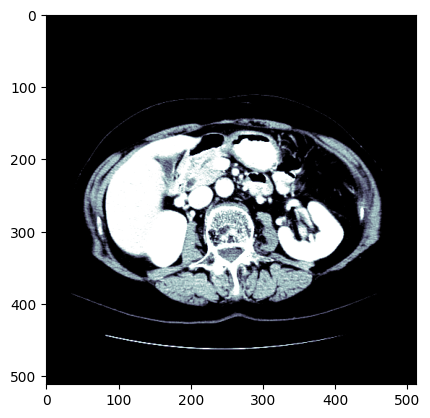

In [10]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [11]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

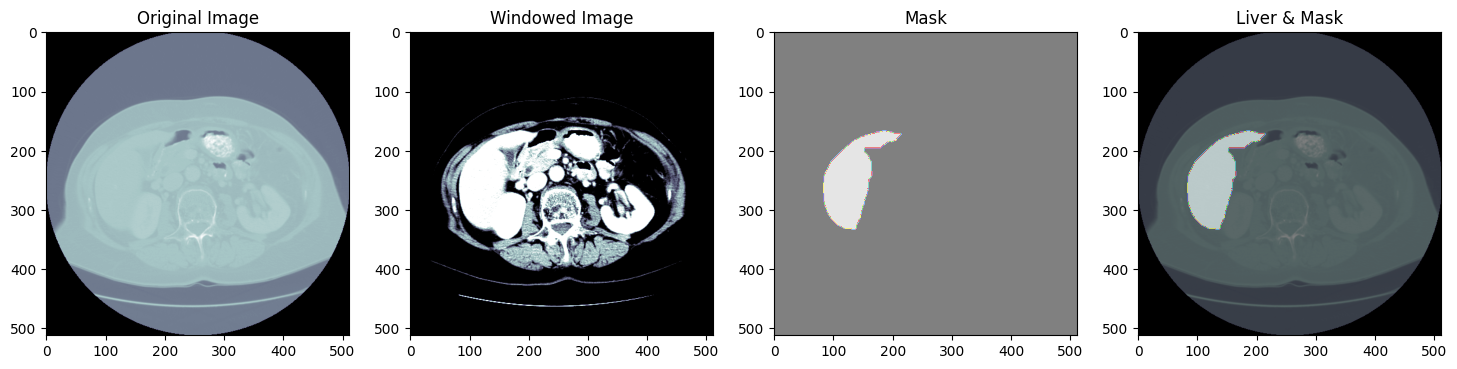

In [12]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [13]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 252049]
 [     1  10095]]


### Data Pre-processing

<Axes: >

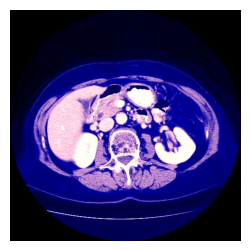

In [14]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])


In [15]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    
    path = Path("E:/New folder/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output


  0%|          | 0/34 [00:00<?, ?it/s]

### Model Training

In [16]:
bs = 16
im_size = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')


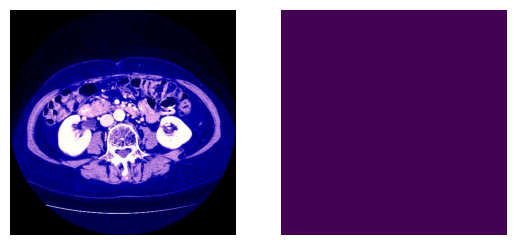

In [17]:
idx=20
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i]) #, cmap='gray'

In [18]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)


[[     0 262144]]


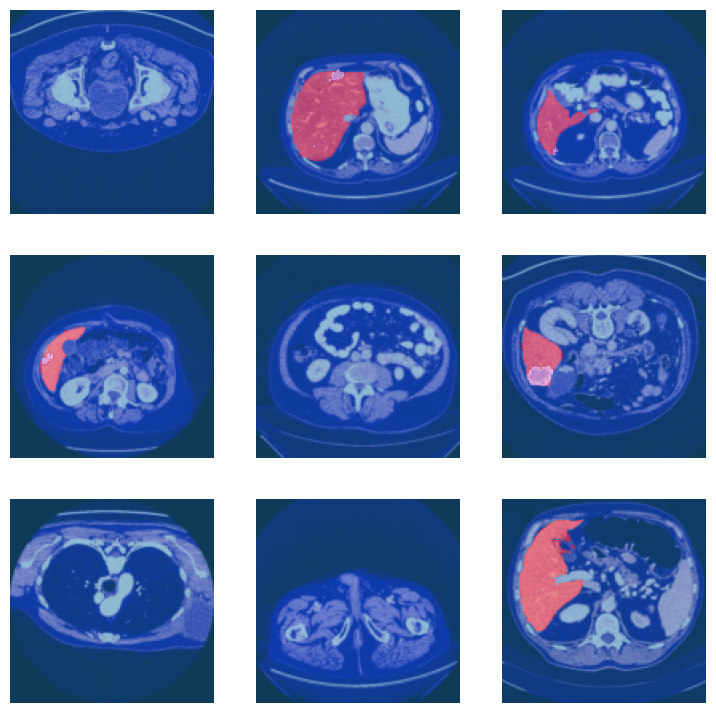

In [19]:
dls = db.dataloaders(path/'train_images',bs = bs) #, num_workers=0
dls.show_batch()

### Cyclical Learning

In [20]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

In [21]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc]) 

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_locat

SuggestedLRs(valley=9.120108734350652e-05)

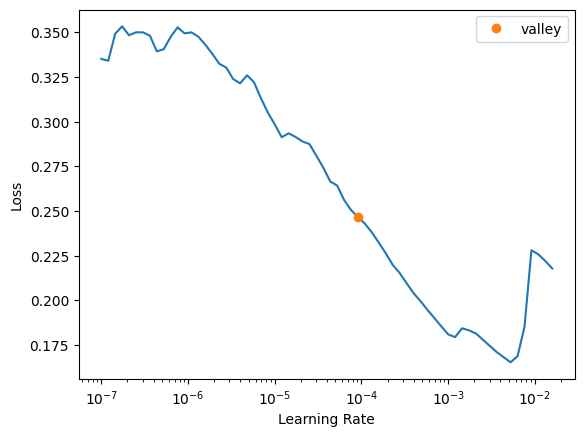

In [22]:
learn.lr_find()

In [23]:
learn.fine_tune(3, wd=0.1, cbs=SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.116855,0.033952,nan,0.988575,1:17:34


Better model found at epoch 0 with valid_loss value: 0.03395197167992592.


epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.011392,0.008144,nan,0.997020,1:13:13
1,0.006159,0.005323,nan,0.997950,1:14:26
2,0.004513,0.004595,nan,0.998241,1:26:43


Better model found at epoch 0 with valid_loss value: 0.008143890649080276.
Better model found at epoch 1 with valid_loss value: 0.005323351826518774.
Better model found at epoch 2 with valid_loss value: 0.004595126956701279.


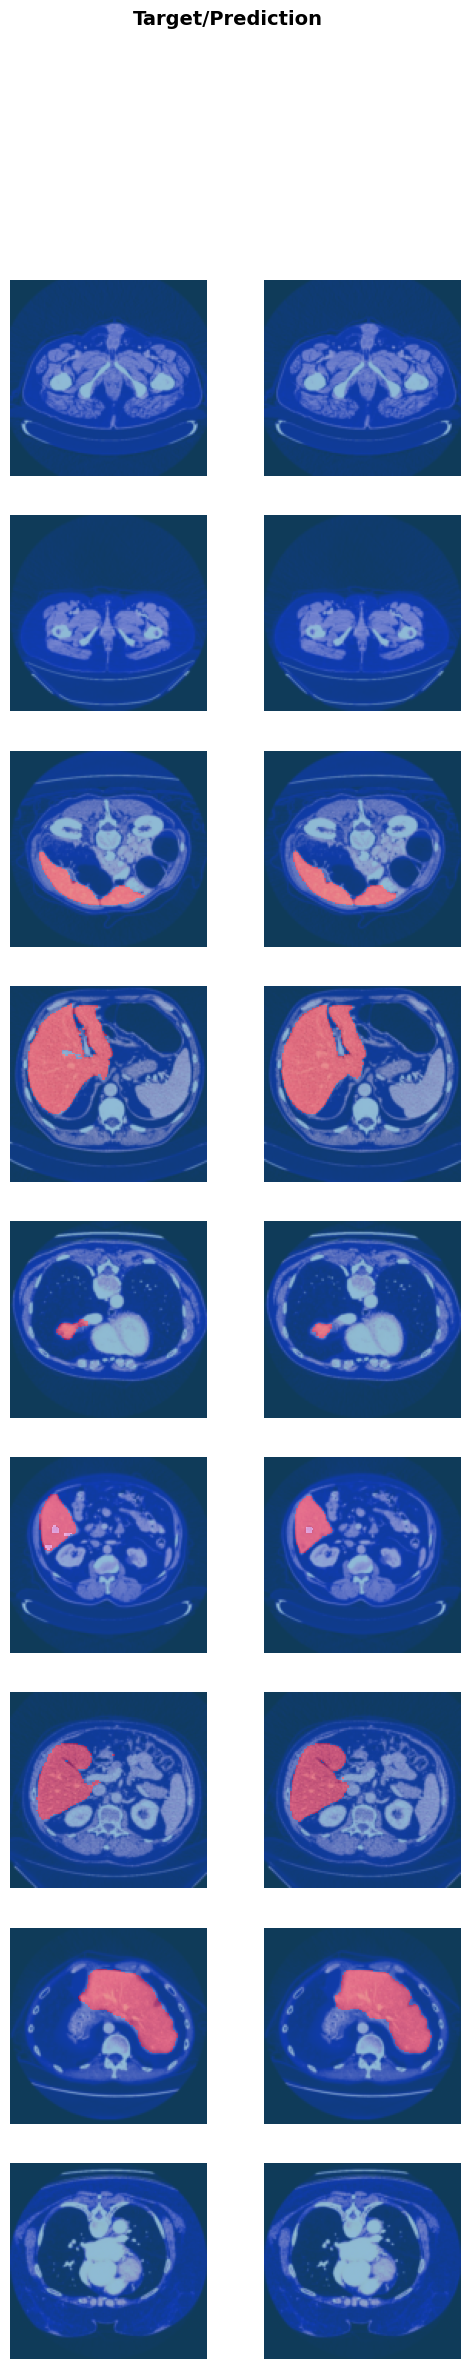

In [24]:
learn.show_results()

In [28]:
# Save the model
learn.export(path/f'E:/New folder/liver-segmentation-with-fastai-v2')

### Model Testing

In [29]:
# Load saved model
if (GENERATE_JPG_FILES) :
    
    tfms = [Resize(im_size), IntToFloatTensor(),Normalize()]
    learn0               = load_learner(path/f'E:/New folder/liver-segmentation-with-fastai-v2',cpu=False )
    learn0.dls.transform = tfms

In [30]:
def nii_tfm(fn,wins): 

    test_nii  = read_nii(fn)
    curr_dim  = test_nii.shape[2] # 512, 512, curr_dim
    slices = []
    
    for curr_slice in range(curr_dim):
        data = tensor(test_nii[...,curr_slice].astype(np.float32))
        data = (data.to_nchan(wins)*255).byte()
        slices.append(TensorImage(data))
                      
    return slices 

In [ ]:
pip install shap

In [ ]:
 #Step 1: Import libraries
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Step 2: Load the image from the local system
image_path = r'C:\Users\USER\Desktop\vc.png'  # Make sure the path is correct and accessible
image = load_img(image_path, target_size=(224, 224))  # Resize to fit model input
image = img_to_array(image)
image = np.expand_dims(image, axis=0)  # Add batch dimension
image = preprocess_input(image)

# Step 3: Load a pre-trained model (e.g., VGG16 or your custom model)
model = VGG16(weights='imagenet', include_top=True)

# Step 4: Perform prediction on the image
preds = model.predict(image)
print(f"Predicted class: {tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0]}")

# Step 5: Explain the prediction using SHAP
explainer = shap.DeepExplainer(model, image)
shap_values = explainer.shap_values(image)

# Step 6: Visualize the SHAP values on the image
shap.image_plot(shap_values, np.array([image[0]]))


(512, 512, 861)


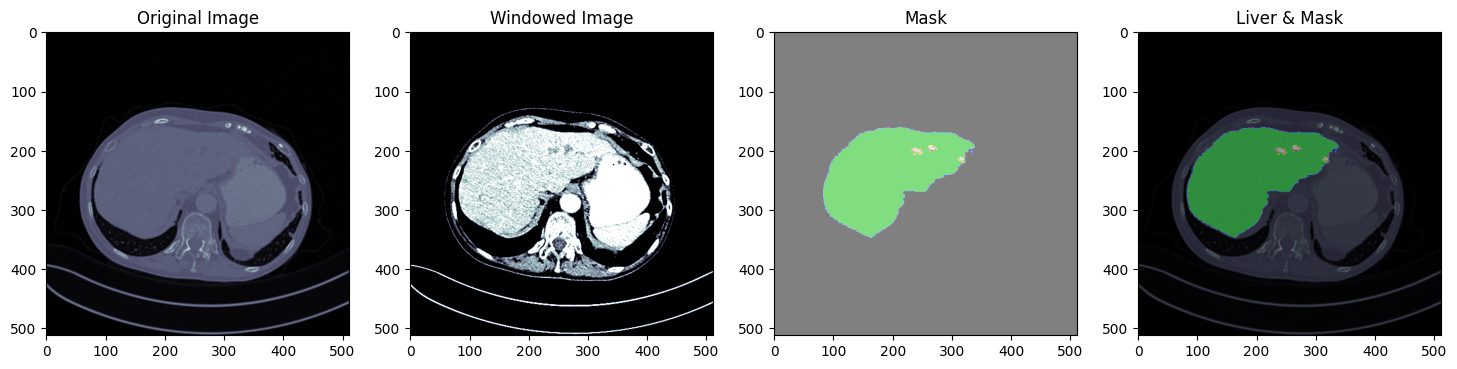

In [32]:
tst = 21

test_nii   = read_nii(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'])
test_mask  = read_nii(df_files.loc[tst,'mask_dirname']+"/"+df_files.loc[tst,'mask_filename'])
print(test_nii.shape)

test_slice_idx = 500

sample_slice = tensor(test_nii[...,test_slice_idx].astype(np.float32))

plot_sample([test_nii[...,test_slice_idx], test_mask[...,test_slice_idx]])

In [33]:
# Prepare a nii test file for prediction 

test_files = nii_tfm(df_files.loc[tst,'dirname']+"/"+df_files.loc[tst,'filename'],[dicom_windows.liver, dicom_windows.custom])
print("Number of test slices: ",len(test_files))

Number of test slices:  861


<Axes: >

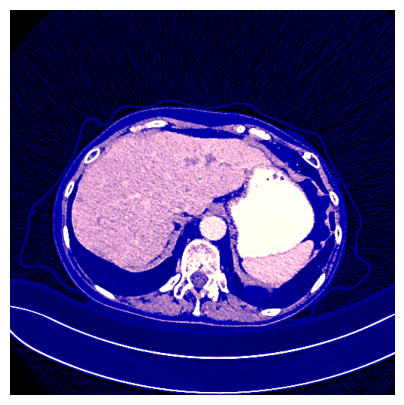

In [34]:
# Check an input for a test file
show_image(test_files[test_slice_idx])

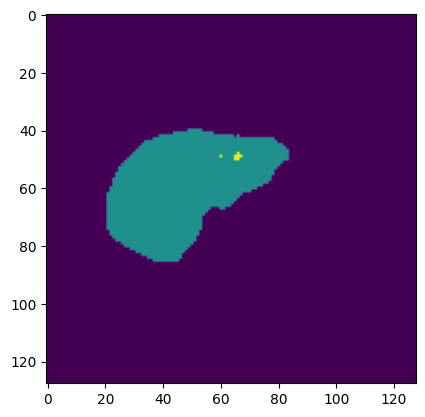

In [35]:
# Get predictions for a Test file

test_dl = learn0.dls.test_dl(test_files)
preds, y = learn0.get_preds(dl=test_dl)

predicted_mask = np.argmax(preds, axis=1)
plt.imshow(predicted_mask[test_slice_idx])

In [36]:
a=np.array(predicted_mask[test_slice_idx])
np.amin(a),np.amax(a)

(0, 2)

# Data Preparation for Machine Learning Algorithms

In [61]:
pip install --upgrade nbformat


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\USER\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [39]:
X = sample_ct
y = sample_mask

X = X.reshape(X.shape[0] * X.shape[1], X.shape[2])
y = y.reshape(y.shape[0] * y.shape[1], y.shape[2])
X.shape, y.shape

((262144, 75), (262144, 75))

# Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

In [41]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [42]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training and Testing

In [43]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier = MultiOutputClassifier(rf, n_jobs = -1)
classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                       n_estimators=10,
                                                       random_state=42),
                      n_jobs=-1)

In [44]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [45]:
print('Our prediction accuracy for Random Forest is: {score}%'.format(score=classifier.score(X_test, y_test) * 100))

Our prediction accuracy for Random Forest is: 96.60493238474889%


# Decision Tree

In [46]:
from sklearn import tree

### Model Training and Testing

In [47]:
dt = tree.DecisionTreeClassifier()
clf = MultiOutputClassifier(dt, n_jobs = -1)
clf = clf.fit(X_train, y_train)

In [48]:
# Predicting the Test set results
y_pred = clf.predict(X_test)

In [49]:
print('Our prediction accuracy for Decision Tree is: {score}%'.format(score=clf.score(X_test, y_test) * 100))

Our prediction accuracy for Decision Tree is: 92.32676572126114%
